### Auto-Generated Code Cells

The following code cells contain code from external .py files that has been automatically added to remove these dependencies. This allows you to run this version of the SELENE notebook on Cloud platforms such as Google Colab. Run all following code cells before starting with the actual notebook content. 

Most Cloud platforms such as Google Colab have a wide range of Python packages preinstalled. However, if any import statements in the following code cells throws an error because of a missing package, you can create and run a new code cell to install the missing package using the `pip` command as shown here:
```
!pip install <package-name>
```

You can use the code cell below for convenience.

In [ ]:
#!pip install <package-name>

In [ ]:
# === Inline content for module src.utils.libimports.rope  ==

# === Inlined imports ===
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn

# === Embedded configs ===


# === Inlined definitions ===


In [ ]:
# === Inline content for module src.utils.plotting.rope  ==

# === Inlined imports ===
import numpy as np
import matplotlib.pyplot as plt

# === Embedded configs ===


# === Inlined definitions ===
def show_radian_example(theta):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_aspect('equal')
    circle = plt.Circle((0, 0), 1, color='lightgray', fill=False, linestyle='--')
    ax.add_artist(circle)
    x = np.cos(theta)
    y = np.sin(theta)
    plt.quiver(0, 0, 1, 0, angles='xy', scale_units='xy', scale=1, color='k', label='Input vector')
    plt.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color='b', label='Rotated vector')
    arc = np.linspace(0, theta, 100)
    ax.plot(np.cos(arc), np.sin(arc), 'r', lw=2, label=f'Arc length = {theta:.2f} radian')
    ax.text(0.5, 0.1, f'{theta:.2f} radian', fontsize=12, color='red')
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)
    ax.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def plot_vectors(vectors, styles=None, colors=None, labels=None, width_factor=1, legend_loc='lower right'):
    origin = np.zeros((len(vectors), 2))
    vectors = np.array(vectors)
    if colors is None:
        colors = ['b'] * len(vectors)
    plt.figure()
    for idx, vec in enumerate(vectors):
        try:
            label = labels[idx]
        except:
            label = ''
        try:
            label = labels[idx]
        except:
            label = ''
        plt.quiver(0, 0, vec[0], vec[1], angles='xy', scale_units='xy', scale=1, color=colors[idx], width=width_factor * 0.01, label=label)
    all_coords = np.vstack((origin, vectors))
    max_val = np.abs(all_coords).max() * 1.2
    plt.xlim(-max_val, max_val)
    plt.ylim(-max_val, max_val)
    plt.axhline(0, color='k', lw=1)
    plt.axvline(0, color='k', lw=1)
    plt.gca().set_aspect('equal')
    plt.grid(True)
    if labels is not None:
        plt.legend(loc=legend_loc)
    plt.show()

<img src="https://raw.githubusercontent.com/chrisvdweth/selene/refs/heads/master/notebooks/images/logo/selene-logo-640.png" style="max-height:75px;" alt="SELENE Logo" />

**Disclaimer:** This Jupyter Notebook contains content generated with the assistance of AI. While every effort has been made to review and validate the outputs, users should independently verify critical information before relying on it. The SELENE notebook repository is constantly evolving. We recommend downloading or pulling the latest version of this notebook from Github.

# Rotary Position Embeddings (RoPE)

**Rotary Positional Embeddings (RoPE)** are a modern positional encoding technique designed to enhance how Transformer models understand the order of tokens in a sequence. In Transformer architectures, which lack inherent knowledge of sequence order due to their non-recurrent, fully parallel structure, positional encoding is essential. RoPE introduces a novel approach by encoding positional information directly into the query and key vectors via position-dependent rotations, rather than by adding or injecting fixed positional vectors into the input. This design makes it possible for Transformers to capture **both absolute and relative positions** more effectively within the self-attention mechanism.

To understand the motivation for RoPE, it is helpful to first consider the limitations of traditional **absolute positional encodings**, such as those used in the original Transformer model. These encodings &mdash; either learned or fixed (e.g., using sinusoidal functions) &mdash; are added to the input token embeddings to indicate each token’s position. However, because they are tight to specific indices, they struggle to capture relative distances between tokens, which are often more important in tasks like natural language understanding. Moreover, learned absolute embeddings cannot generalize to sequences longer than those seen during training, which limits model flexibility.

On the other hand, **relative positional encodings** (like those used in Transformer-XL or T5) attempt to address this by injecting information about the distance between tokens directly into the attention calculation. While this improves the model's ability to handle long-range dependencies and sequence extrapolation, many relative encoding schemes introduce extra complexity and parameters, and can be cumbersome to integrate or scale, especially in multi-head attention.

RoPE strikes a balance by encoding relative positional information implicitly through **rotations of vector components** based on position. It does so without adding trainable parameters and with minimal computational cost. By rotating the query and key vectors in each attention head according to sinusoidal functions of their positions, RoPE ensures that the dot product between these vectors reflects their relative positional difference. This allows models to naturally attend to how far apart two tokens are, making RoPE both efficient and expressive.

In summary, RoPE is motivated by the need for a position encoding method that is lightweight, generalizable, and capable of encoding relative relationships—without the complexity of bias matrices or the limitations of fixed embeddings. It has become a widely adopted strategy in modern large language models like LLaMA due to its strong theoretical foundations and practical benefits in long-context modeling.

### Setting up the Notebook

#### Make Required Imports

This notebook requires the import of different Python packages but also additional Python modules that are part of the repository. If a package is missing, use your preferred package manager (e.g., [conda](https://anaconda.org/anaconda/conda) or [pip](https://pypi.org/project/pip/)) to install it. If the code cell below runs with any errors, all required packages and modules have successfully been imported.

#### Preliminaries

Before delving into masking, there are a few preliminary comments to outline the scope of this notebook:

* This notebook assumes that you are familiar with the concept of attention and multi-head attention. If not, we recommend that you first cover this topic before continuing.

* To make all visualizations, examples, and descriptions easier to understand, we assume that any input text is tokenized into proper words. Note that practical Transformer-based models typically rely on subword-based tokenizers (e.g., Byte-Pair Encoding, WordPiece).

With these clarifications out of the way, let's get started...

---

## Quick Recap: Basic Vector Rotation

Vector rotation using matrices is a mathematical method for changing the direction of a vector while preserving its magnitude. This is commonly done in 2D or 3D space using rotation matrices. A **rotation matrix** is a special type of square matrix that, when multiplied with a vector, rotates it around the origin by a specific angle. In 2D, the rotation matrix for an angle $\theta$ is:

$$\large
\mathbf{R}_\theta = 
\begin{bmatrix}
    \cos{\theta} & -\sin{\theta}\\
    \sin{\theta} & \cos{\theta}
\end{bmatrix}
$$

If we want to rotate a vector $\mathbf{x} = [x_1, x_2]^T$ by an angle of $\theta$ radians to get a new vector $\mathbf{x}^\prime = [x^\prime_1, x^\prime_2]^T$, we have to calculate $\mathbf{x}^\prime = \mathbf{R}_\theta \mathbf{x}$; more specifically:

$$\large
\begin{bmatrix}
   x^\prime_1 \\
   x^\prime_2
\end{bmatrix}
= \mathbf{R}_\theta
\begin{bmatrix}
   x_1 \\
   x_2
\end{bmatrix} =
\begin{bmatrix}
    \cos{\theta} & -\sin{\theta}\\
    \sin{\theta} & \cos{\theta}
\end{bmatrix}
\begin{bmatrix}
   x_1 \\
   x_2
\end{bmatrix}
$$

If $\theta$ is positive, the rotation is counterclockwise &mdash; assuming standard right-handed Cartesian coordinate system. If $\theta$ is negative, the rotation is clockwise.

The angle $\theta$ in a rotation matrix is given in radians and not in degrees. A **radian** is a unit of angular measure used in mathematics, especially in trigonometry and calculus. One radian is defined as the angle created when the arc length of a circle is equal to the radius of the circle. In other words, if you take the radius of a circle and bend it along the edge of the circle, the angle that this arc subtends at the center is $1$ radian.

Radians are used because they provide a direct, natural relationship between angles and arc lengths in mathematical formulas, especially in trigonometry and calculus. Most importantly, when using functions like sine and cosine &mdash; which are fundamental to rotation matrices &mdash; their derivatives and behaviors are simplest and most consistent when angles are measured in radians. For example, only when the angle $\theta$ is in radians, the following identities hold:
* The derivative of $\sin{\theta}$ is $\cos(\theta)$
* The derivative of $\cos(\theta)$ is $-\sin{\theta}$

If degrees were used instead of radians, you'd have to include extra conversion factors, which would complicate calculations and distort the clean mathematical properties of rotation matrices. Because radians tie directly to the geometry of circles (as the ratio of arc length to radius), they are the most natural and efficient unit for defining rotations in mathematical and physical systems.

To give an example, the code cell below uses an auxiliary method to plot two vectors of length $1$. The black vector lies on the x-axis, and the blue vector is the result of rotating the black vector by $\theta$ radians. The red arc visualizes the radian as the arc length of the circle (segment) described by the rotation.

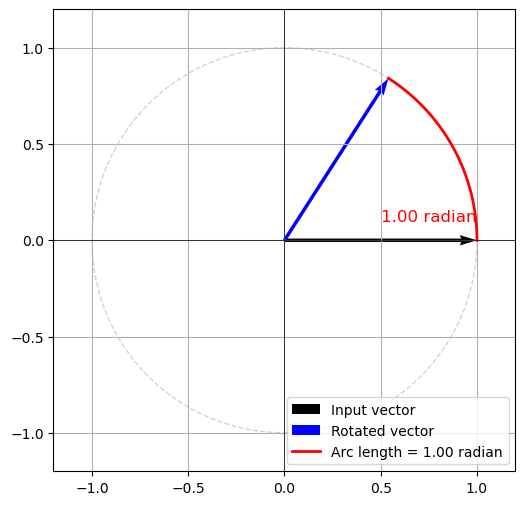

In [2]:
theta = 1
#theta = -1
#theta = np.pi/2
#theta = -np.pi/2

show_radian_example(theta)

For `theta=1`, by definition, we therefore have an arc length that is the same length as the radius of the circle.

**Your turn:** Try running the previous code cell with different values for `theta`. For example, for $\theta = \pi/2$. You should see that the black and the blue vector form a right angle of $90^{\circ}$ (here: degrees!). You can also add a negative sign to the value of $\theta$ to switch from a counterclockwise to a clockwise rotation.

Given the formula above, we can directly implement the rotation of a 2D vector as a method `rotate()`; see the code cell below. This method takes a vector and an angle $\theta$ (in radians!) as input, and returns the vector rotated by $\theta$. We represent both the rotation matrix and input vector as NumPy arrays to simplify the matrix multiplication. The `@` operator in NumPy is used for matrix multiplication (also known as the dot product for vectors or matrix product for arrays). It provides a clean and readable way to multiply two arrays following the rules of linear algebra.

In [3]:
def rotate(vector, theta):
    # Calculate rotation matrix R
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])
    # Convert vector numpy array (just a fail-safe of not already a numpy array)
    vector = np.array(vector)
    # Calculate and return rotated vector as product of rotation matrix and input vector
    return np.matmul(R, vector)

To show an example usage, we mimic the plot from above. For this, we first have to create a `black` that represents the black vector. We then apply the method `rotate()` to this vector with the same value for $\theta$ used for the plot to get the rotated vector `blue`. Lastly, we simply print the rotated vector to inspect the result.

In [4]:
# Define vector of length 1 on the x-axis
black = [1, 0]
# Rotate vector by theta
blue  = rotate(black, theta) 
# Output rotated vector (rounded)
print(f"Rotated vector: {blue.round(2)}")

Rotated vector: [0.54 0.84]


The exact result will naturally depend on your choice for $\theta$. For example, for $\theta = 1$, you should see `[0.54, 0.84]`; for $\theta = \pi/2$ you should see `[0, 1]` since the rotated vector false onto the y-axis. Of course, `back` can be an arbitrary vector. We only set it to `[1, 0]` so the reflects to example plot above.

---

## Rotation for Positional Encoding

Vector rotation using matrix operations is the foundation of RoPE, where the vectors are the embedding vectors in the query and key space of the attention mechanisms. Let's explore how rotation is used as a positional encoding strategy to capture both the word order and relative positions between words in a sentence.

### 2D Case

RoPE must be integrated directly into the attention mechanism because their core purpose is to encode positional information in relation to the word interactions during attention computation. Unlike absolute positional embeddings (which are added to token embeddings before attention), **RoPE modifies the query and key vectors** within the dot-product attention so that the attention scores themselves inherently reflect the relative positions between tokens. This design is key for preserving the model's ability to generalize to sequences longer than those seen during training.

Although query and key vectors have a size of 64 or several hundred entries, let's first consider the 2D case &mdash; that is, where all query and key vectors are only of size one. The reason is that only in a 2D space a rotation matrix has only one degree of freedom because a 2D rotation is completely determined by a single angle $\theta$ &mdash; the amount of rotation around the origin. In higher-dimensional spaces the number of degrees of freedom increases which also makes it no longer unambiguous what we mean by a rotation of a vector in a high-dimensional space. We will address the step to higher dimensions further down below.

Consider the following two example sentences, both containing the words *"bus"* and *"cab"* in the same order and with the same relative distance. While words between *"bus"* and *"cab"* are the same in this simple example, this is not important. After both sentences, in parenthesis, the example states the respective position of both words in each sentence. For example, the first sentence, the word *"bus"* is at position $4$. Recall that we start with position $1$ (instead of $0$) to align with the original [RoPE paper](https://arxiv.org/abs/2104.09864). Also, we count punctuation marks as a word &mdash; but after all, the absolute positions do not matter, which is exactly what we want to show.

* *"I took the <ins>bus</ins> and then a <ins>cab</ins> after work"* (position of *"bus"*: 4; position of *"cab"*: 8)

* *"During the last two weeks, when my car was in the shop for repair, I took the <ins>bus</ins> and then a <ins>cab</ins> after work."* (position of *"bus"*: 20; position of *"cab"*: 24)

Let's now assume those sentences for the input for a Transformer model. This means that all words, including *"bus"* and *"cab"*, are first encoded as their initial word embedding vectors $\mathbf{w}_i$, including $\mathbf{x}_{bus}$ and $\mathbf{x}_{cab}$. As part of the attention mechanism, all words are then projected into the query, key, and value space. Since RoPE only rotates the query and key vectors, we can limit ourselves in this example to the query vectors $\mathbf{q}_{bus}$ and $\mathbf{q}_{cab}$, as well as the key vectors $\mathbf{k}_{cab}$ and $\mathbf{k}_{bus}$. In fact, we can limit ourselves to focus on the single word pair $\mathbf{q}_{bus}$ and $\mathbf{k}_{bus}$, as it captures all relevant insights.

In [5]:
q_bus = np.asarray([0.5, 0.3])
k_cab = np.asarray([0.6, -0.2])

We provide an auxiliary method to `plot_vectors()` to easily visualize vectors in a 2D space. So let's simply do this for the query vector $\mathbf{q}_{bus}$ and the key vector $\mathbf{k}_{cab}$.

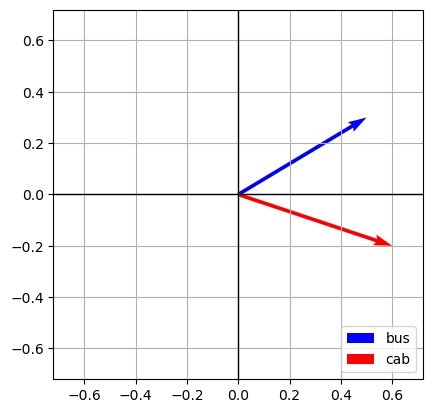

In [6]:
plot_vectors([q_bus, k_cab], colors=['b', 'r'], labels=["bus", "cab"])

Take a moment to appreciate that, without any additional positional encoding, the dot product between $\mathbf{q}_{bus}$ and $\mathbf{k}_{cab}$ would always be the same independent of (a) the relation position of both words and (b) the order of both words. So how can we apply rotation to capture both these important aspects of words in a sequence? To this end, RoPE multiplies the rotation angle $\theta$ with the position $m$ of a word before applying the sine and cosine function. Thus, the rotation matrix for RoPE look as follows:

$$\large
\mathbf{R}_{\theta,m} = 
\begin{bmatrix}
    \cos{m\theta} & -\sin{m\theta}\\
    \sin{m\theta} & \cos{m\theta}
\end{bmatrix}
$$

The most straightforward observation is that the word embedding vectors that appear later in a sequence are rotated by a larger overall angle $m\theta$ than words appearing earlier in the sequence. This also implies that the word order now matters since swapping two words in a sequence affects how much they are rotated. It can also be shown &mdash; the mathematical details are omitted here but can be found in the [RoPE paper](https://arxiv.org/abs/2104.09864) &mdash; that the resulting angle and therefore the dot product does only depend on the relative distance between embedding vectors and not the absolution position of their corresponding words in a sequence.

To illustrate this, let's go through an example using our query vector $\mathbf{q}_{bus}$ and key vector $\mathbf{k}_{cab}$. In the following, we set the rotation angle to an arbitrary value, here: $\theta = 0.1$ radians.

In [7]:
theta = 0.1

We already know that in our first example sentence *"I took the <ins>bus</ins> and then a <ins>cab</ins> after work"* that the word *"bus"* it at position $4$, and the word *"cab"* is at position 8. After defining both positions as variables and rotating $\mathbf{q}_{bus}$ and $\mathbf{k}_{cab}$ using our `rotate()` method; and then again plot both rotated vectors.

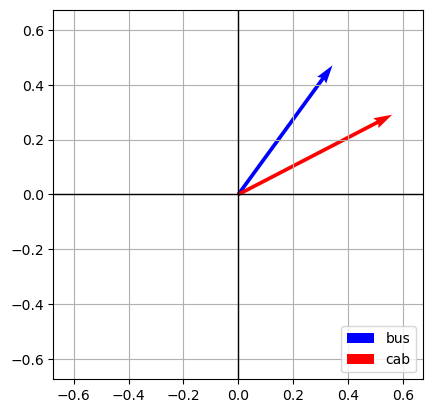

In [8]:
m1_bus, m1_cab = 4, 8

q_bus_rotated1 = rotate(q_bus, m1_bus*theta)
k_cab_rotated1 = rotate(k_cab, m1_cab*theta)

plot_vectors([q_bus_rotated1, k_cab_rotated1], colors=['b', 'r'], labels=["bus", "cab"])

As expected, both vectors have been rotated counterclockwise since $\theta$, and with that $m\theta$, is a positive value. We can also see that the angle between the rotated vectors is not smaller compared to the angle between original word embedding vectors $\mathbf{x}_{bus}$ and $\mathbf{x}_{cab}$. Again, this is not a surprise since *"cab"* appears later that *"bus"* in the sequence and therefore gets rotated more.

In the context of the attention mechanism, we do not directly care about the angle between vectors but their dot product. So let's calculate the dot product between the rotated query and key vector &mdash; rotated with respect to their positions in the first example sentence.

In [9]:
print(f"The dot product between q_bus_rotated1 and k_cab_rotated1 is: {q_bus_rotated1.dot(k_cab_rotated1):.3f}")

The dot product between q_bus_rotated1 and k_cab_rotated1 is: 0.330


For the moment the actual value of the dot product is not that interesting. To change this, let's perform the exact same rotation and dot product calculations for $\mathbf{q}_{bus}$ and $\mathbf{k}_{cab}$, but now regarding their positions in the second example sentence. Recall, that in the second sentence, the word *"bus"* is at position $20$, and the word *"cab"* is at position $24$. The code cell below defines both positions as variables and again rotates both vectors and plots the rotated result vector.

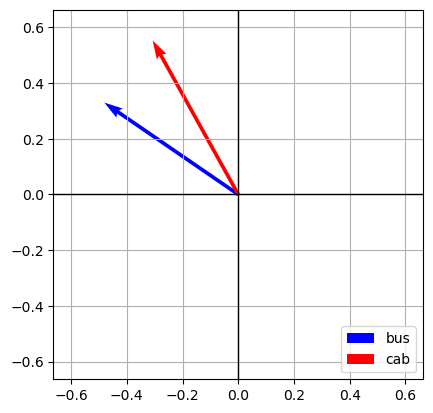

In [10]:
m2_bus, m2_cab = 20, 24

q_bus_rotated2 = rotate(q_bus, m2_bus*theta)
k_cab_rotated2 = rotate(k_cab, m2_cab*theta)

plot_vectors([q_bus_rotated2, k_cab_rotated2], colors=['b', 'r'], labels=["bus", "cab"])

Both the query and key vectors are now rotated even further since both words appear much later in the second sentence compared to the first sentence. However, just from comparing the plots, we can already see that the angle between the rotated vectors has remained the same. To confirm this, let's again compute the dot product between the vectors.

In [11]:
print(f"The dot product between q_bus_rotated2 and k_cab_rotated2 is: {q_bus_rotated2.dot(k_cab_rotated2):.3f}")

The dot product between q_bus_rotated2 and k_cab_rotated2 is: 0.330


As you can see, the dot product is the same for both example sentences. In other words, the dot product only depends on the relative distance between words but not on their absolute distance, which is exactly what we were aiming for (but again, this behavior is not obvious and needs to be shown that it always holds).

To to give some counterexamples, let's first pretend that the positions of *"bus"* and *"cab"* have been swapped in the second sentence. We can quickly simulate this by swapping the variables `m2_cab` and `m2_bus` in our example code, where `m2_cab` is used to rotate `q_bus`, and `m2_bus` is used to the rotate `k_cab`; see the code cell above.

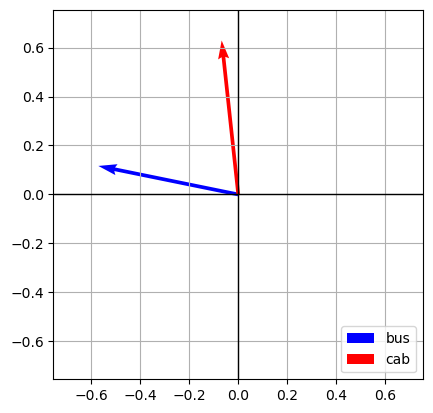

In [12]:
q_bus_rotated_swapped = rotate(q_bus, m2_cab*theta)
k_cab_rotated_swapped = rotate(k_cab, m2_bus*theta)

plot_vectors([q_bus_rotated_swapped, k_cab_rotated_swapped], colors=['b', 'r'], labels=["bus", "cab"])

We can clearly see that the angle between both vectors has increased since $\mathbf{q}_{bus}$ was already "ahead" of $\mathbf{k}_{cab}$ with respect to a counterclockwise rotation and $\mathbf{q}_{bus}$ got now rotated more than $\mathbf{k}_{cab}$. So once again, **word order matters**! Lastly, we can also check the case where our two words *"bus"* and *"cab"* have a different relative position. To simulate this case, let's assume that the word *"cab"* is not at position $28$ and no longer at position $24$.

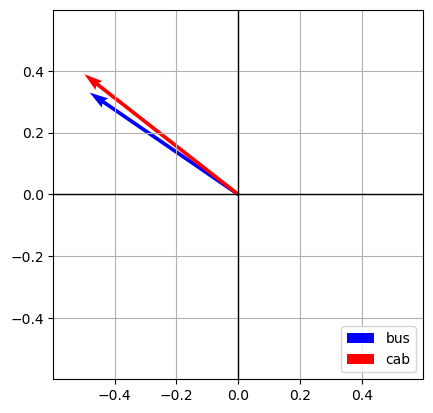

In [13]:
m2_cab_new = 28

q_bus_rotated_farther = rotate(q_bus, m2_bus*theta)
k_cab_rotated_farther = rotate(k_cab, m2_cab_new*theta)

plot_vectors([q_bus_rotated_farther, k_cab_rotated_farther], colors=['b', 'r'], labels=["bus", "cab"])

The only important observation is, again, that the angle, and with that the dot product, between the rotated vectors is different. This illustrates that the the **relative position matters**!

### From 2D to Higher Dimensions

So far, we looked at the rotation of vectors in a 2-dimensional space. This is the most basic and intuitive situation since in 2 dimensions there is only one way that a vector can rotate, so rotation has 1 degree of freedom, represented by an angle $\theta$ &mdash; also note that, by definition, a vector cannot rotate in a 1-dimensionsional space. The number of degrees of freedom increases with the number of dimensions. For example there are 3 degrees of freedom in 3D spaces and 6 degrees in 4D spaces. Of course, word embedding vectors &mdash; including the vectors in the query, key, and value space of the attention mechanism in Transformers &mdash; reside in high-dimensional spaces. Below is a table showing the size of query and key vectors for several popular LLMs.

| Model                | Hidden Size ($d_{\text{model}}$) | Attention Heads | Query/Key Size |
| -------------------- | -------------------------------- | --------------- | -------------- |
| **GPT-2 Small**      | 768                              | 12              | 64             |
| **GPT-3 (175B)**     | 12288                            | 96              | 128            |
| **GPT-3 Ada (2.7B)** | 2560                             | 32              | 80             |
| **LLaMA 2 (7B)**     | 4096                             | 32              | 128            |
| **LLaMA 2 (13B)**    | 5120                             | 40              | 128            |
| **LLaMA 2 (70B)**    | 8192                             | 64              | 128            |
| **PaLM (540B)**      | 18432                            | 48              | 384            |
| **BERT Base**        | 768                              | 12              | 64             |
| **BERT Large**       | 1024                             | 16              | 64             |
| **T5 (Base)**        | 768                              | 12              | 64             |
| **T5 (Large)**       | 1024                             | 16              | 64             |

In short, even the smallest query and key vector have a size of at least 64.

#### Rotation Matrix

A very common approach to implement rotation in high-dimensional spaces &mdash; and also the one utilized in the original [RoPE paper](https://arxiv.org/abs/2104.09864) &mdash; is the concept of an orthogonal decomposition of the high-dimensional space into a union of orthogonal two-dimensional subspaces. The transformation looks like a planar (i.e., 2D rotation) rotation when restricted to any one of the two-dimensional subspaces. In simple terms, this means that we consider any vector $\mathbf{x}$ of size $d$ as a combination of $d/2$ 2D vectors and independently apply a 2D rotation to each of those "subvectors". This assumes that $d$ is even, which is basically always true for word embedding vectors. Since we have $d/2$ independent 2D rotations, we now need to specify $d/2$ angles, collectively denoted as vector $\mathbf{\Theta}$, i.e.:

$$\large
\mathbf{\Theta} = [ \theta_1, \theta_2, \dots, \theta_{d/2} ]
$$

The result rotation matrix $\mathbf{R}^{d}_{\mathbf{\Theta},m}$ is shown below. Notice the superscript $d$ representing the dimension of the query and key space in the attention mechanism.

$$\large
R^{d}_{\mathbf{\Theta},m} = 
\begin{bmatrix}
    \cos{m\theta_1} & -\sin{m\theta_1}   &  0   & 0  &  \cdots & 0  & 0 \\
    \sin{m\theta_1} & \cos{m\theta_1}   &  0   & 0  &  \cdots & 0  & 0 \\
    0 &  0  & \cos{m\theta_2} & -\sin{m\theta_2} & \cdots & 0  & 0 \\
    0 &  0  & \sin{m\theta_2} & \cos{m\theta_2} & \cdots & 0  & 0 \\
    \vdots &  \vdots  & \vdots  & \vdots  & \ddots  & \vdots & \vdots \\
    0 &  0  & 0  & 0  & \cdots  & \cos{m\theta_{d/2}} & -\sin{m\theta_{d/2}} \\
    0 &  0  & 0  & 0  & \cdots  & \sin{m\theta_{d/2}} & \cos{m\theta_{d/2}} 
\end{bmatrix}
$$

Again, assuming $\mathbf{x}$ denoting the input vector and $\mathbf{x}^\prime$ the rotated vector, we now have to calculate $\mathbf{x}^\prime = \mathbf{R}^{d}_{\mathbf{\Theta},m} \mathbf{x}$. While we can implement this matrix multiplication "as is" &mdash; using the definition of $\mathbf{R}^{d}_{\mathbf{\Theta},m}$ as a $d\times d$ rotation matrix &mdash; the sparsity of $\mathbf{R}^{d}_{\mathbf{\Theta},m}$ also for a more efficient implementation using the following alternative formula:

$$\large
\mathbf{x}^\prime = \mathbf{R}^{d}_{\Theta,m} \mathbf{x} =
\begin{bmatrix}
   x_1 \\
   x_2 \\
   x_3 \\
   x_4 \\
   \vdots \\   
   x_{d-1} \\
   x_d \\
\end{bmatrix} \otimes
\begin{bmatrix}
   \cos{m\theta_1} \\
   \cos{m\theta_1} \\
   \cos{m\theta_2} \\
   \cos{m\theta_2} \\
   \vdots \\   
   \cos{m\theta_{d/2}} \\
   \cos{m\theta_{d/2}} \\
\end{bmatrix} + 
\begin{bmatrix}
   -x_2 \\
   x_1 \\
   -x_4 \\
   x_3 \\
   \vdots \\   
   -x_d \\
   x_{d-1} \\
\end{bmatrix} \otimes
\begin{bmatrix}
   \sin{m\theta_1} \\
   \sin{m\theta_1} \\
   \sin{m\theta_2} \\
   \sin{m\theta_2} \\
   \vdots \\   
   \sin{m\theta_{d/2}} \\
   \sin{m\theta_{d/2}} \\
\end{bmatrix}
$$

#### Choice of $\Theta$ Values

For the value of $\mathbf{\Theta} = \{ \theta_1, \theta_2, \dots, \theta_{d/2} \}$, the original [RoPE paper](https://arxiv.org/abs/2104.09864) relies of the same approach as the original [Transformer paper](https://arxiv.org/abs/1706.03762) of using sinusoidal functions. The periodic nature of sine and cosine functions is key to their effectiveness. By using different frequencies for different dimensions of the positional encoding vector, a unique "fingerprint" can be created for each positional information. While the original Transformer uses this idea to add absolute positional encodings to the word embeddings before the first attention layer, RoPE directly incorporates the positional information into the attention mechanism's query and key vectors through a rotation. More specifically, the $\mathbf{\Theta}$ values are calculate as:

$$\large
\mathbf{\Theta} = \left\{\theta_i = B^{-2(i-1)/d}, \ i\in [1, 2, \dots, d/2] \right\}
$$

where $B$ represents the **base** to control the range of frequencies; in the both original [RoPE](https://arxiv.org/abs/2104.09864) and [Transformer](https://arxiv.org/abs/1706.03762) papers, the base frequency is set to $B=10,000$. The exponent $-2(i-1)/d$ scales the input so that lower dimensions correspond to higher-frequency sinusoids (rapid changes), and higher dimensions correspond to lower-frequency sinusoids (slow changes). This spread of frequencies allows the model to represent both fine-grained (local) and coarse-grained (global) positional relationships.

Apart from creating unique rotations and preserving the the encoded relative position between two words is independent from their absolute position in a sequence (see above) &mdash; which are the most important goals of RoPE &mdash; the use of sinusoidal function as additional characteristics:

* **Effective training:** Using sine and cosine ensures that the rotations are smooth and differentiable. Smooth functions change gradually with respect to position, which helps neural networks learn patterns in sequences more consistently. This continuity ensures that nearby positions in a sequence have similar encodings, allowing the model to detect local structures and transitions more easily, such as the relationship between adjacent words or tokens. Differentiability is crucial because neural networks are trained using gradient-based optimization methods like backpropagation. If the positional encoding functions were not differentiable, gradients could not flow properly through them, and the model would struggle to learn how to use position information effectively.

* **Long-term decay:** The range of both the sine and cosine functions is $[−1,1]$. This means that no matter what input (angle in radians) you give to the sine or cosine function, the output will always fall between –1 and 1, inclusive. This bounded output is a key property that makes them suitable for encoding periodic patterns, such as positions in sequences. Additionally, the use of different frequency for different dimensions provides as long-term decay property, meaning that the product between the rotated query and key vectors during the attention calculation will decay for increasing relative positions (more details and the proof can be found in the original [RoPE paper](https://arxiv.org/abs/2104.09864)). This seems like an intuitive property since the farther two words are apart the less likely they have a meaningful connection &mdash; although other works have challenged this assumption (see discussion below).

Given the definition of $\mathbf{\Theta}$, we can easily implement the calculation of all $\theta_i$ values for a given value for $d$, i.e., the size of the query and key vectors during the attention calculation. In the code cell below, to keep it simple, we set $d=16$. We also define the base $B$ using a variable. Like in the [RoPE](https://arxiv.org/abs/2104.09864) and [Transformer](https://arxiv.org/abs/1706.03762) papers, we set $B = 10,000$ by default, but other works experiment with other (typically higher) values. The [`arange()`](https://docs.pytorch.org/docs/stable/generated/torch.arange.html) method in PyTorch creates a 1D tensor with evenly spaced values within a specified interval. It takes arguments like `start`, `end`, and `step`, and generates values from start (inclusive) up to but not including end, incremented by step.

In [14]:
# Define size of query/value vectors and base
d, B = 16, 10000

# Calculate all d/2 theta_i values
Theta = 1.0 / (B ** (torch.arange(0, d, 2).float() / d))

# Show the calculated theta values as column vector
print(Theta.view(-1, 1))

tensor([[1.0000e+00],
        [3.1623e-01],
        [1.0000e-01],
        [3.1623e-02],
        [1.0000e-02],
        [3.1623e-03],
        [1.0000e-03],
        [3.1623e-04]])


Notice that we only need eight $\theta$ values since each $\theta_i$ is used twice as part of the rotation calculation. This example output also shows that the $\theta_1$ for the lowest two dimensions is largest with $\theta_1 = 1$. With increasing dimension, the $\theta_i$ values decrease.

Of course, for the final rotation, we still have to multiply the $\mathbf{\Theta}$ with each word's position $m$ &mdash; that is, we have to calculate all values $m\theta_i$ &mdash; before applying the results to the sine of cosine functions. Assuming an input sequence of length $L$, we need to consider positions $m$ with $1 \leq m \leq L$. The code cell below shows how we can quickly generate all possible positions in PyTorch; again, we use the `arange()` method from PyTorch for that. We set sequence length to $L=10$ by default to keep it simple, but feel free to change it to see its effects.

In [15]:
# Define length of sequence
L = 10

# Create array [1, 2, ..., L]
positions = torch.arange(L).float() + 1

# Show all positions
print(f"All possible positions (L={L}): {positions}")

All possible positions (L=10): tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])


Denoting the list of all possible positions $m$ as vector $\mathbf{m}$. we can now calculate the matrix $\mathbf{F}$ containing all frequencies $m\theta_i$ as $\mathbf{F} = \mathbf{m}\theta^\top$. This means we get all $m\theta_i$ values from the outer product of the vectors $\mathbf{}$ and $\mathbf{\Theta}$. The [`outer()`](https://docs.pytorch.org/docs/stable/generated/torch.outer.html) method in PyTorch computes the outer product of two 1-dimensional tensors (vectors), resulting in a 2-dimensional tensor (matrix). This operation essentially creates a grid of all pairwise multiplications between elements of the two vectors.

In [16]:
# Create all frequencies, i.e., m-theta pa
F = positions.outer(Theta)

print(f"Size of F: {F.shape}\n")

# Show the first 5 row and the first 5 colum values
print(F[:5,:5])

Size of F: torch.Size([10, 8])

tensor([[1.0000, 0.3162, 0.1000, 0.0316, 0.0100],
        [2.0000, 0.6325, 0.2000, 0.0632, 0.0200],
        [3.0000, 0.9487, 0.3000, 0.0949, 0.0300],
        [4.0000, 1.2649, 0.4000, 0.1265, 0.0400],
        [5.0000, 1.5811, 0.5000, 0.1581, 0.0500]])


$\mathbf{F}$ contains no all frequencies $m\theta_i$ to perform the rotation $\mathbf{R}^{d}_{\Theta,m} \mathbf{x}$ of an embedding vector $\mathbf{x}$. Since $\mathbf{F}$ only depends on the length of the sequence &mdash; and many sequence a trained with a maximum sequence length &mdash; and not any input in terms of the, all frequencies $m\theta_i$ can be precomputed and cached to improve performance.

### Integration into Attention Mechanism

Recall that attention is calculated is the following formula:

$$\large
\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{softmax}\left(\frac{\mathbf{Q}\mathbf{K}^\top}{\sqrt{d_k}} \right) \mathbf{V}
$$

where $\mathbf{Q}$, $\mathbf{K}$, and $\mathbf{V}$ are tensors containing word embedding vectors in the query, key, and value space using the weight matrices $\mathbf{W}_q$, $\mathbf{W}_k$, and $\mathbf{W}_v$. In case of self-attention, all three weight matrices received the same sequence of initial word embedding vectors. In cross attention, only $\mathbf{W}_k$, and $\mathbf{W}_v$ receive the same input sequence (i.e., the output of the Transformer encoder), while $\mathbf{W}_q$ receives the input from the Transformer encoder.

RoPE only affects the calculation of the attention scores $\mathbf{A}_{scores}$ (i.e., $\mathbf{A}_{scores} = \mathbf{Q}\mathbf{K}^\top$). In other words, RoPE rotates only the query and key vectors &mdash; but not the value vectors &mdash; because its primary goal is to encode positional information into the attention scores, not the values being passed through. Rotating the value vectors would interfere with the actual content being passed to the next layer. Unlike $\mathbf{Q}$ and $\mathbf{K}$, which serve to determine how much attention to pay to each token, $\mathbf{V}$ represents what information gets passed forward. Keeping $\mathbf{V}$ untouched ensures that positional encoding does not distort the underlying token content. In essence, RoPE respects the separation of concerns: $\mathbf{Q}$ and $\mathbf{K}$ are about *where* information is, while $\mathbf{V}$ is about *what* the information is. This design preserves semantic integrity while enriching the attention mechanism with positional awareness.

Thus, on an abstract level, we now want to calculate attention using the rotated query vectors $\mathbf{Q}_{rope}$ and key vectors $\mathbf{K}_{rope}$:

$$\large
\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{softmax}\left(\frac{\mathbf{Q}_{rope}\mathbf{K}^\top_{rope}}{\sqrt{d_k}} \right) \mathbf{V}
$$

In the basic attention mechanism, both $\mathbf{Q}$ and $\mathbf{K}$ are computed as a projection by multiplying the input word embedding vectors with the transformation matrices $\mathbf{W}_q$ and $\mathbf{W}_k$, respectively. Although rotation is also implemented as a matrix multiplication, the rotation matrix $\mathbf{R}^{d}_{\mathbf{\Theta},m}$ depends on a words position $m$ in the sequence. We therefore have to look at the computation of the individual dot products between the query and key vectors. For example, without any rotation, the attention score between our two words *"bus"* and *"cab"* are calculated as follows:

$$\large
\mathbf{q}^\top_{bus}\mathbf{k}_{cab} = \left(\mathbf{W}_q \mathbf{x}_{bus} \right)^\top \left(\mathbf{W}_k \mathbf{x}_{cab} \right)
$$

where $\mathbf{x}_{bus}$ and $\mathbf{x}_{cab}$ are the input word embedding vectors for *"bus"* and *"cab"*, respectively. With this, we can now incorporate the rotation step by adding the multiplications with the corresponding rotation matrices to the formula. Again, appreciate how the positions of both words are captured by the two parameters $m_{bus}$ and $m_{cab}$ of the rotation matrix $\mathbf{R}^{d}_{\mathbf{\Theta},m}$.

$$\large
\mathbf{q}^\top_{bus}\mathbf{k}_{cab} = \left(R^{d}_{\mathbf{\Theta},m_{bus}}\mathbf{W}_q \mathbf{x}_{bus} \right)^\top \left(R^{d}_{\mathbf{\Theta},m_{cab}}\mathbf{W}_k \mathbf{x}_{cab} \right)
$$

where $m_{bus}$ and $m_{cab}$ are the positions of the words *"bus"* and *"cab"* in the input sequence. Thus, we can now the matrix $\mathbf{A}_{scores}$ containing all the attention scores &mdash; assuming self-attention here, where $\mathbf{A}_{scores}$ is a square matrix of size $L\times L$, and $L$ being the length of the input sequence &mdash; as follows:

$$\large
\mathbf{A}_{scores} = 
\begin{bmatrix}
    \mathbf{q}^\top_{1}\mathbf{k}_{1} & \mathbf{q}^\top_{1}\mathbf{k}_{2} &  \mathbf{q}^\top_{1}\mathbf{k}_{3} &  \cdots & \mathbf{q}^\top_{1}\mathbf{k}_{L}  \\
    \mathbf{q}^\top_{2}\mathbf{k}_{1} & \mathbf{q}^\top_{2}\mathbf{k}_{2} &  \mathbf{q}^\top_{2}\mathbf{k}_{3}  &  \cdots & \mathbf{q}^\top_{2}\mathbf{k}_{L} \\
    \mathbf{q}^\top_{3}\mathbf{k}_{1} & \mathbf{q}^\top_{3}\mathbf{k}_{2} &  \mathbf{q}^\top_{3}\mathbf{k}_{3}  & \cdots & \mathbf{q}^\top_{3}\mathbf{k}_{L}  \\
    \vdots &  \vdots  & \vdots  & \ddots & \vdots \\
    \mathbf{q}^\top_{L}\mathbf{k}_{1} & \mathbf{q}^\top_{L}\mathbf{k}_{2} &  \mathbf{q}^\top_{L}\mathbf{k}_{3}  & \cdots  & \mathbf{q}^\top_{L}\mathbf{k}_{L}
\end{bmatrix}
$$

Recall that $R^{d}_{\mathbf{\Theta},m}$ can be derived from the precomputed frequencies $m\theta_i$. Also, the actual rotation operation rotation $\mathbf{R}^{d}_{\Theta,m} \mathbf{x}$ is done in practice using the more efficient implementation as shown above. However, a complete and optimized implementation of RoPE as part of the attention mechanisms is not trivial and beyond the scope of this notebook.

---

## Discussion

Rotary Position Embeddings (RoPE) are a widely adopted technique for positional encoding in Large Language Models (LLMs) due to their ability to encode relative position relationships and their flexibility with varying sequence lengths. Many popular LLMs utilize RoPE, including LLaMA (Meta), Mistral (Mistral AI), Gemma (Google), and PaLM (Google). RoPE has become a standard in the LLM landscape because it allows models to effectively handle long sequences and extrapolate to lengths beyond what they were trained on, which is a significant advantage in many real-world applications.

### Benefits and limitations

RoPE offers several significant advantages over traditional positional encoding methods, especially in the context of Transformer-based models. One of the most important benefits is that RoPE encodes relative positional information directly into the attention mechanism. By rotating the query and key vectors based on their position, RoPE allows the attention scores to naturally reflect the relative distance between tokens. This contrasts with absolute positional embeddings, which only indicate a token's fixed position and do not provide information about how far one token is from another.

Another key advantage is that RoPE enables extrapolation to longer sequences than seen during training. Because it uses a deterministic, sinusoidal rotation function (similar in spirit to sinusoidal embeddings), the model can generalize to sequences longer than the maximum length it was trained on, unlike learned positional embeddings which are fixed in size. This makes RoPE especially valuable for applications that deal with variable-length inputs or require processing longer contexts (e.g., long-form document understanding, code generation, or protein sequence modeling).

Furthermore, RoPE is parameter-free and lightweight, adding no trainable parameters and minimal computational overhead. This keeps the model size smaller and training more efficient while still improving its ability to model positional relationships. The mathematical simplicity of rotating vector pairs using sine and cosine functions also means RoPE is easy to implement and integrate into existing architectures with minimal changes, making it a practical and powerful enhancement for many Transformer models.

However, RoPE does come with some limitations and disadvantages

* **Fixed Functional Form.** RoPE uses a fixed sinusoidal rotation pattern that is not learnable. While this makes RoPE lightweight, adding only minimal computational overhead, it also means it cannot adapt to specific task or data characteristics. This can limit its flexibility compared to learnable position embeddings that can tailor themselves to the training data.
 
* **Need for even-dimensional head sizes.** RoPE operates by rotating pairs of dimensions (like 2D vectors), so it requires the dimension of each attention head to be even. If the embedding size is not divisible by 2 or is not structured properly, RoPE cannot be applied directly without padding or reshaping. However, this is rarely a concern in practice since head sizes are typically even.

* **Hard to interpret or modify.** The rotation mechanism is mathematically elegant but less interpretable than absolute position embeddings or even relative position bias matrices. It is also harder to debug or modify, especially in custom architectures.

* **Not compatible with all attention variants.** RoPE integrates tightly into the scaled dot-product attention mechanism, but may not be directly compatible with attention variants. Different variants of the attention mechanism have been proposed because the original scaled dot-product attention, has its own limitations in efficiency, scalability, and expressiveness. Alternative alternative forms of attention have been proposed to address specific challenges in various use cases, such as handling longer sequences, reducing computational cost, or improving generalization. Such alternatives may significantly alter how queries and keys are processed. Adapting RoPE to such variants may require nontrivial modification.

As a consequence, positional encodings &mdash; including variants and alternatives to RoPE &mdash; remain an active field of research.

### Performance Considerations

In this notebook, we focused on the underlying ideas and concepts behind RoPE. Although we saw how RoPE is integrated in the attention mechanism of a Transformer architecture, we omitted a completed discussion about its implementation. While is generally a light-weight strategy for positional encoding, ensuring a fast and efficient implementation requires some careful thoughts &mdash; which are simply outside the scope of this notebook.

---

### Summary

Rotary Positional Embeddings (RoPE) are a positional encoding strategy used in Transformer-based models to represent the order of tokens in a sequence. Unlike absolute position embeddings, which assign a fixed positional vector to each token index, RoPE encodes positional information by rotating the query and key vectors in the attention mechanism using position-dependent trigonometric functions. This approach allows the model to capture relative positional relationships directly in the attention scores, making it more flexible and generalizable to inputs of varying lengths.

One of the key advantages of RoPE is its ability to support relative positioning without requiring additional parameters or complex bias matrices. By rotating each pair of dimensions in the query and key vectors based on token position, RoPE enables the model to recognize not just where tokens appear in a sequence, but how far apart they are. This is especially useful in tasks where the relationship between tokens depends more on relative distance than absolute position &mdash; such as in language modeling, code understanding, and time-series forecasting.

RoPE is also computationally efficient and parameter-free, meaning it does not increase the model size or add overhead during training and inference. Furthermore, because it relies on deterministic sinusoidal functions, RoPE supports extrapolation to longer sequences than the model was trained on, something that absolute or learned positional embeddings struggle with. These properties make RoPE particularly attractive for large-scale models and applications involving long documents or dialogues.

Understanding RoPE is important for anyone working with or researching Transformer architectures, especially as it becomes a standard component in many modern large language models (LLMs). As Transformers evolve to handle longer context windows and more complex dependencies, mastering efficient and expressive positional encoding methods like RoPE is essential for optimizing performance and generalization. 

In short, RoPE represents a significant advancement in how models understand sequence order, bridging the gap between efficiency and expressiveness. Learning about RoPE helps developers and researchers design more scalable, accurate, and versatile Transformer-based systems that perform well across a wide range of tasks and sequence lengths.